# 2. Data Simulation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import importlib
import json

from pathlib import Path
from scipy.stats import uniform, norm, gamma

# setting font sizeto 16
plt.rcParams.update({'font.size': 16})

In [2]:
MAIN_DIR = Path.cwd().parent
DATA_DIR = MAIN_DIR / 'data'
EXP_DIR = MAIN_DIR / 'experiments'
NOTEBOOKS_DIR = MAIN_DIR / 'notebooks'
RESULTS_DIR = MAIN_DIR / 'results'
SRC_DIR = MAIN_DIR / 'src'

FIGURES_DIR = RESULTS_DIR / 'figures'

In [3]:
sys.path.append(str(SRC_DIR))

import simulation
importlib.reload(simulation)

from simulation import (
    LotkaVolterraSimulator,
    RosenzweigMacArthurSimulator,
    HollingSimulator,
    StochasticLotkaVolterraSimulator,
    FullPredatorPreyModel,
    create_and_save_simulated_data
)

### 2.1 Simulating Data with Lotke-Volterra

$$ \frac{dA}{dt} = rA - \alpha AR $$
$$ \frac{dR}{dt} = \beta AR - dR $$

Parameters:
- $A$ = Algae population (prey)
- $R$ = Rotifer population (predator)
- $r$ = Growth rate of algae
- $\alpha$ = Predation rate (how well rotifers consume algae)
- $\beta$ = Reproduction efficiency of rotifers
- $d$ = Rotifer mortality rate

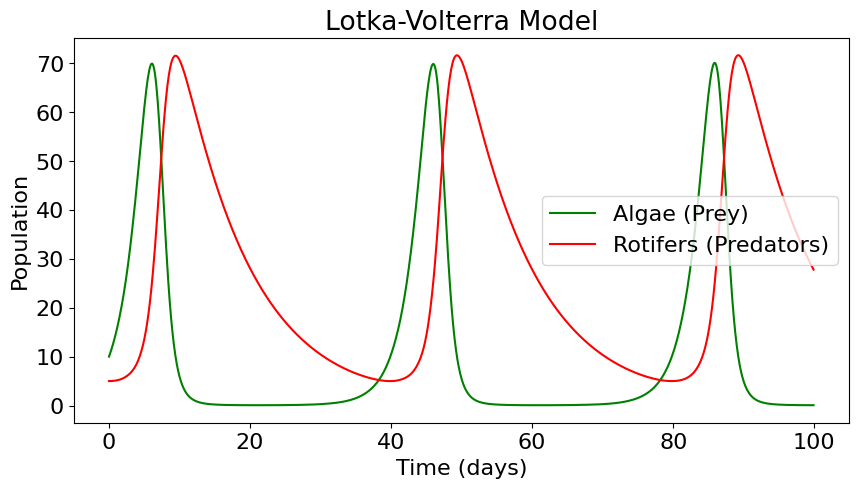

In [51]:
params = {"r": 0.5, "alpha": 0.02, "beta": 0.01, "d": 0.1}
initial_conditions = (10, 5)  # Starting algae & rotifer populations
t_range = (0, 100, 1000)  # Simulate from t=0 to t=100 with 1000 time points

lv_sim = LotkaVolterraSimulator(params, initial_conditions, t_range)
solution = lv_sim.simulate()
lv_sim.plot_results(solution, title="Lotka-Volterra Model")

### 2.2 Stochastic Lotka-Volterra Model

We include random environmental variations like temperature fluctuations, nutrient availability and random mortality by formulating the dynamics in a stochastic differential equation:

$$ dA = (rA - \alpha A R) dt + \sigma_A A D W_A $$
$$ dR = (\beta A R - d R) dt + \sigma_R R d W_R $$

with $dW_A$ and $dW_R$ as random noise terms and $\sigma_A$ and $\sigma_R$ as noise strengths.

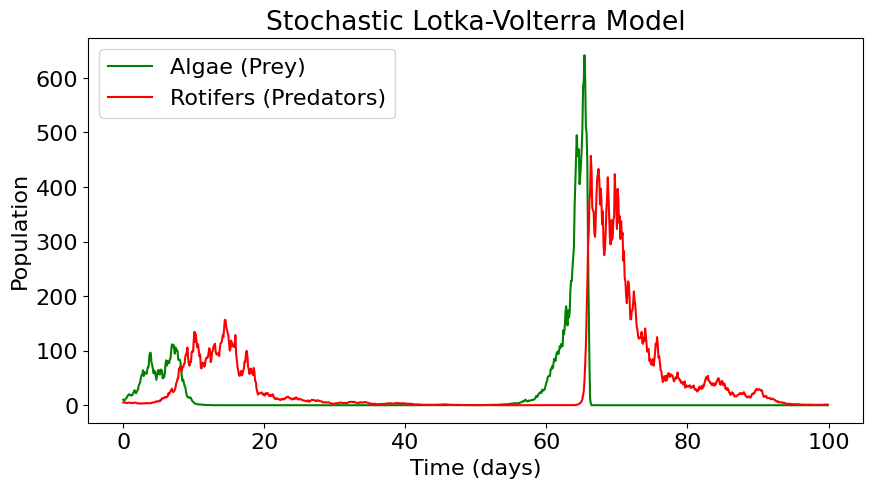

In [52]:
params = {
    "r": 0.5,
    "alpha": 0.02,
    "beta": 0.01,
    "d": 0.1,
    "sigma_A": 0.1,
    "sigma_R": 0.1}

initial_conditions = (10, 5)  # Starting algae & rotifer populations
t_range = (0, 100, 1000)  # Simulate from t=0 to t=100 with 1000 time points

lv_sim = StochasticLotkaVolterraSimulator(params, initial_conditions, t_range)
solution = lv_sim.simulate()
lv_sim.plot_results(solution, title="Stochastic Lotka-Volterra Model")

### 2.3 Full Model

The full model which is taken from the Time Series paper takes into account state variables like the concentration of nitrogen $N$, phytoplankton $P$ (algae), the three life stages of the predator, namely eggs $E$, juveniles $J$ and adults $A$. Additionally the model keeps track of the dead animals $D$ in the chemostat. There is an assumed time delay $\theta$ for egg development, a constant time delay $\tau$ for jeveniles and adults. The phytoplancton population is assumed to be unstructured.

$$ \frac{dN}{dt} = \delta N_{in} - F_P(N)P - \delta N $$
$$ \frac{dP}{dt} = F_P(N)P - F_B(P)B/\epsilon - \delta P $$
$$ \frac{dE}{dt} = R_E - R_J - \delta E $$
$$ \frac{dJ}{dt} = R_J - R_A - (m + \delta) J $$
$$ \frac{dA}{dt} = \beta R_A - (m + \delta) A $$
$$ \frac{dD}{dt} = m (J + A) - \delta D $$

$\beta$ is the adult/juvenile mass ratio (juvenile/egg mass ratio is assumed to be 1). The recruitment rates are:

$$ R_E(t) = F_B(P(t)) A(t) $$
$$ R_J(t) = R_E(t - \theta) \exp{(-\delta \theta)} $$
$$ R_A(t) = R_J(t - \tau) \exp{(-\delta \tau)} $$

The algal nutrient uptake $F_P(N)$ is modelled as a type-3 functional response with Hill coefficient $\kappa$:

$$ F_P(N) = r_P \frac{N}{K_P + N} $$
$$ F_B(P) = r_B \frac{P^\kappa}{K_B^\kappa + P^\kappa} $$

The total predator density is given by $B(t) = \beta J(t) + A(t)$ and the egg ratio is $\beta E(t) / B(t)$. As state variables are given in units of nitrogen, juveniles and eggs here need to be scaled by the adult/juvenile mass ratio $\beta$.
<br>

Stochasticity is included by taking the growth rates $r_P$ and $r_B$ as autocorrelated random numbers by multiplying them with a factor of $1 + s_i$ in every simulation time step. Autocorrelation is $s_{i+1} = as_i + \xi_i$ with autocorrelation_parameter $a$ and i.i.d Gaussian number $\xi_i \sim \mathcal{N}(0, \sigma^2=1-a^2)$.
<br>

Measurement error and additional stochasticies are captured by replacing the sampled rotifer state variables, $E(t)$, $J(t)$, $A(t)$, and $D(t)$, with random variables drawn from a Poission distribution with an expectation value equal to that of the state variable. The algal and rotifer state variables are then rescaled to individuals per volume using constants $\nu_P$ and $\nu_B$.
<br>

For comparison with the original paper: The parameter values were found as follows: <br>
Mass ratio adult/juveniles $\beta = 5$, diluation rate $\delta = 0.55$, nitrogen concentration in external medium $N_{in} = 80 \mu\text{mol\, l}^{-1}$, phytoplankton maximal growth rate $r_P = 3.3$ per day, phytoplankton half-saturation constant $k_P = 4.3 \mu\text{mol\, l}^{-1}$, rotifer maximal egg-recruitment rate $r_B = 2.25$ per day, rotifer half-saturation constant $k_B = 15 \mu\text{mol\, l}^{-1}$, hill coefficient of the functional response $\kappa = 1.25$, predator assimilation efficiency $\epsilon = 0.25$, rotifer mortality rate $m = 0.15$ per day, egg development time $\theta = 0.6$ days, juvenile maturation time $\tau = 1.8$ days, autocorrelation parameter $a = 0.9$, noise strength $\sigma = 0.5$, nitrogen content per adult rotifer $\nu_A = 0.57 \cdot 10^{-3} \mu\text{mol\, N}$, nitrogen content per algal cell, $\nu_P = 28 \cdot 10^{-9} \mu\text{mol\, N}$.
<br>

In the paper the environmental parameters ($\delta$, $N_{in}$) were taken according to the experimental set-up. Parameters for uptake and growth ($r_P$, $k_P$, $r_B$, $k_B$ and $\epsilon$) were taken according to a previous study. The mass ratio ($\beta$) was taken from literature and the parameter values of population dynamics ($\theta$, $\tau$, $\kappa$ and $m$) and stochasticity were adjusted by hand. For us we leave them as open parameters to see how well our model can identify the different parameters.

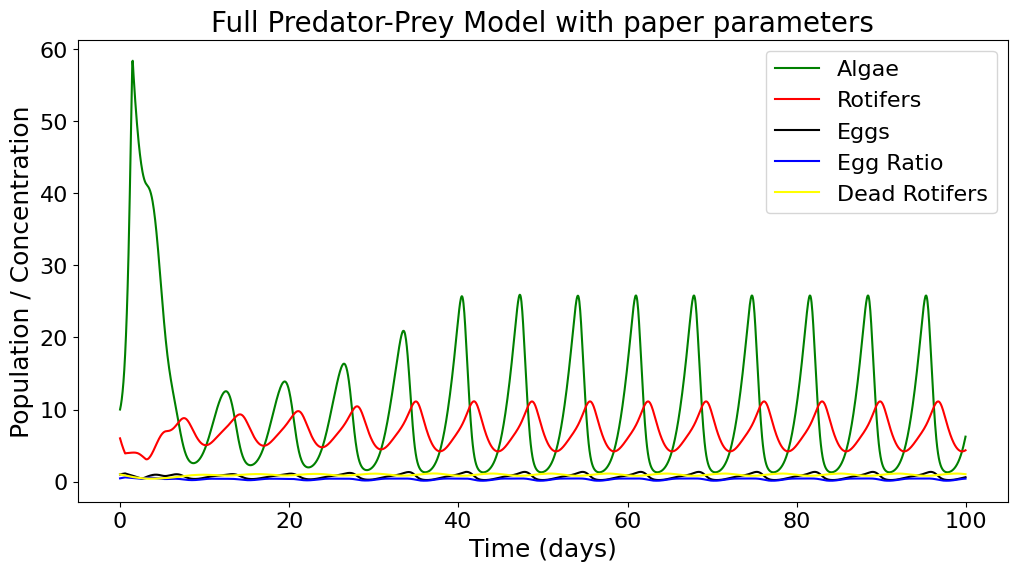

In [53]:
# Perform the full simulation with parameters from the paper
params = {
    'delta': 0.55, 'N_in': 80, 'r_P': 3.3, 'K_P': 4.3,
    'r_B': 2.25, 'K_B': 15, 'kappa': 1.25, 'epsilon': 0.25,
    'm': 0.15, 'beta': 5, 'theta': 0.6, 'tau': 1.8, 'a': 0.9,
    'sigma': 0.5
}

# Initial conditions: [N, P, E, J, A, D]
initial_conditions = [80, 10, 1, 1, 1, 1]
t_range = (0, 100, 2000)  # Simulate for 100 days with 2000 time points

# Run the model
model = FullPredatorPreyModel(params, initial_conditions, t_range, randomize=False)
solution = model.simulate()
model.plot_results(solution, title="Full Predator-Prey Model with paper parameters")

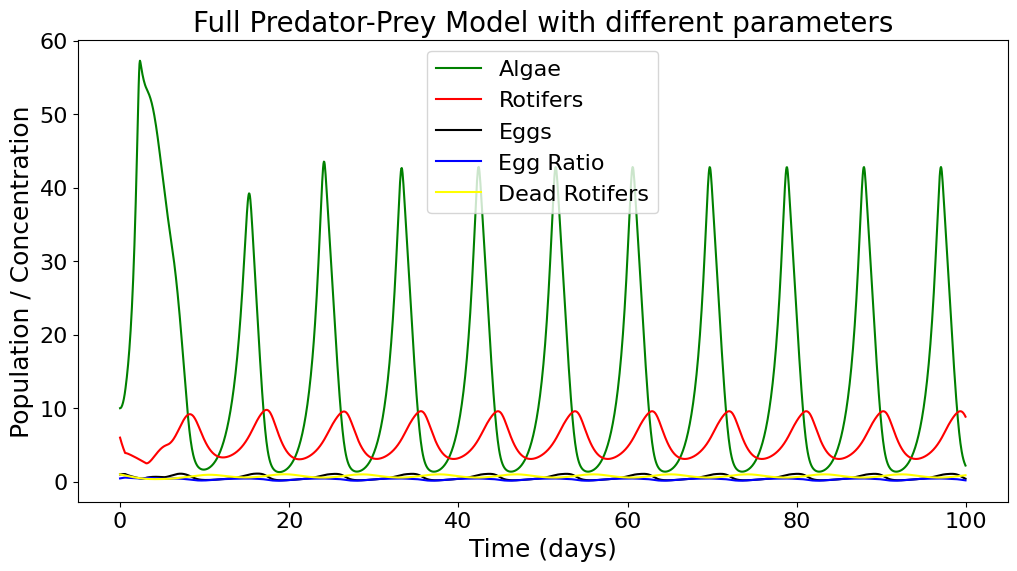

In [54]:
# Now we test the variability by repeating the simulation with different parameters
params = {
    'delta': 0.55, 'N_in': 80, 'r_P': 2.5, 'K_P': 3.8,
    'r_B': 1.9, 'K_B': 14, 'kappa': 1.25, 'epsilon': 0.25,
    'm': 0.15, 'beta': 5, 'theta': 0.6, 'tau': 1.8, 'a': 0.9,
    'sigma': 0.5
}

# Initial conditions: [N, P, E, J, A, D]
initial_conditions = [80, 10, 1, 1, 1, 1]
t_range = (0, 100, 2000)  # Simulate for 100 days with 2000 time points

# Run the model
model = FullPredatorPreyModel(params, initial_conditions, t_range, randomize=False)
solution = model.simulate()
model.plot_results(solution, title="Full Predator-Prey Model with different parameters")

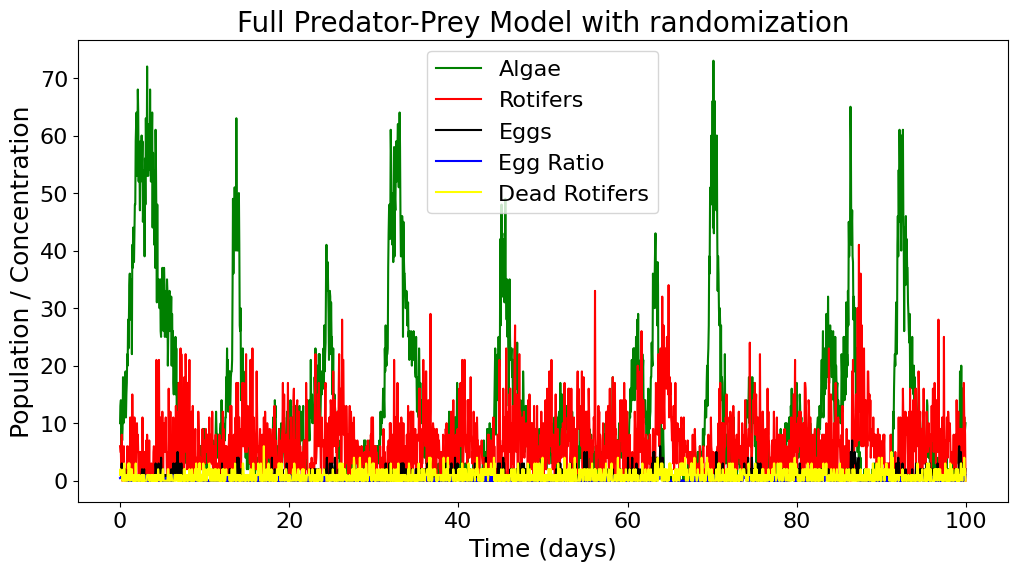

In [55]:
# Now we simulate some data with autocorrelated randomized growth rates and reporting noise
params = {
    'delta': 0.55, 'N_in': 80, 'r_P': 3.3, 'K_P': 4.3,
    'r_B': 2.25, 'K_B': 15, 'kappa': 1.25, 'epsilon': 0.25,
    'm': 0.15, 'beta': 5, 'theta': 0.6, 'tau': 1.8, 'a': 0.9,
    'sigma': 0.5
}

# Initial conditions: [N, P, E, J, A, D]
initial_conditions = [80, 10, 1, 1, 1, 1]
t_range = (0, 100, 2000)  # Simulate for 100 days with 2000 time points

# Run the model
model = FullPredatorPreyModel(params, initial_conditions, t_range, randomize=True)
solution = model.simulate()
model.plot_results(solution, title="Full Predator-Prey Model with randomization")

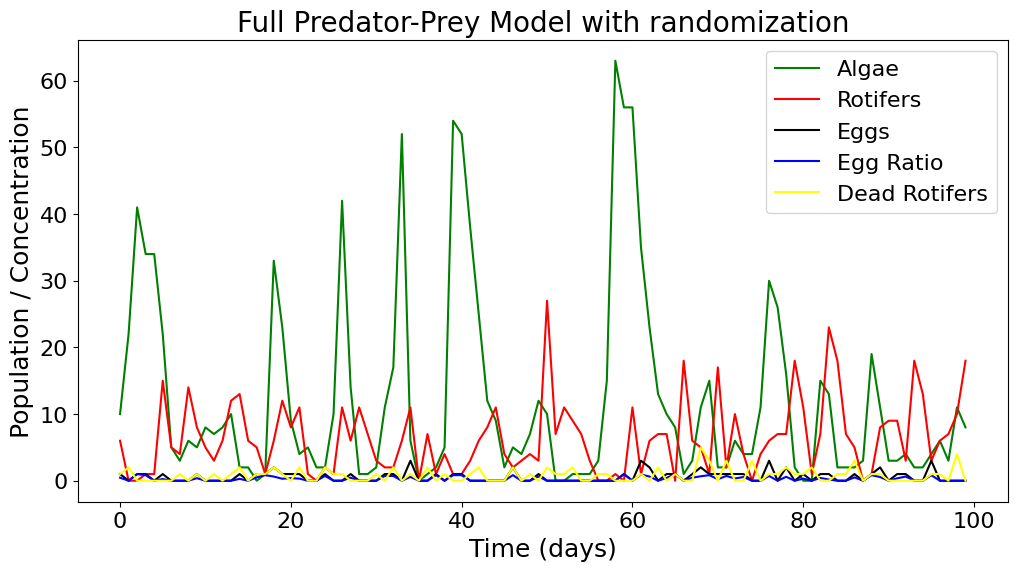

In [56]:
# To make things more visible we will decrease the number of time points
params = {
    'delta': 0.55, 'N_in': 80, 'r_P': 3.3, 'K_P': 4.3,
    'r_B': 2.25, 'K_B': 15, 'kappa': 1.25, 'epsilon': 0.25,
    'm': 0.15, 'beta': 5, 'theta': 0.6, 'tau': 1.8, 'a': 0.9,
    'sigma': 0.5
}

# Initial conditions: [N, P, E, J, A, D]
initial_conditions = [80, 10, 1, 1, 1, 1]
t_range = (0, 100, 2000)  # Simulate for 400 days with 400 time points

# Run the model
model = FullPredatorPreyModel(params, initial_conditions, t_range, randomize=True)
solution = model.simulate()
solution = model.discretize_solution(solution, 1)
model.plot_results(solution, title="Full Predator-Prey Model with randomization")

### 2.4 Defining Prior Distributions

In order to create datasets using the simulators and a set of parameters we need prior distributions of the parameters from which the parameters are drawn from for each simulation run. The priors can later be compared to the posteriors in the neural network.

In [57]:
# TODO: Remake the priors to produce better simulations

priors = {
    "delta": uniform(0.4, 0.3),  # Uniform prior between 0.4 and 0.7
    "N_in": norm(80, 10),        # Normal prior (mean=80, std=10)
    "r_P": gamma(3, scale=1),    # Gamma prior (shape=3, scale=1)
    "r_B": gamma(2, scale=1),    # Gamma prior (shape=2, scale=1)
    "K_P": uniform(3, 3),        # Uniform prior between 3 and 6
    "K_B": uniform(10, 10),      # Uniform prior between 10 and 20
    "kappa": uniform(1, 0.5),    # Uniform prior between 1 and 1.5
    "epsilon": uniform(0.1, 0.4),# Uniform prior between 0.1 and 0.5
    "m": uniform(0.1, 0.2),      # Uniform prior between 0.1 and 0.3
    "beta": uniform(3, 4),       # Uniform prior between 3 and 7
    "theta": uniform(0.3, 0.6),  # Uniform prior between 0.3 and 0.9
    "tau": uniform(1, 2),        # Uniform prior between 1 and 3
    "a": uniform(0, 1),          # Autocorrelation between 0 and 1
    "sigma": uniform(0.01, 0.1)  # Noise level between 0.01 and 0.11
}


Sampled parameters:
{
  "delta": 0.5474596831491373,
  "N_in": 76.02115931630465,
  "r_P": 1.7392031326248178,
  "r_B": 2.223159406498716,
  "K_P": 5.54384838097095,
  "K_B": 19.456282858302025,
  "kappa": 1.422975251833871,
  "epsilon": 0.4698737537554505,
  "m": 0.10428720730086934,
  "beta": 4.65637880687218,
  "theta": 0.38046340088414327,
  "tau": 1.0867759530867076,
  "a": 0.3231417262094156,
  "sigma": 0.09405406572149946
}


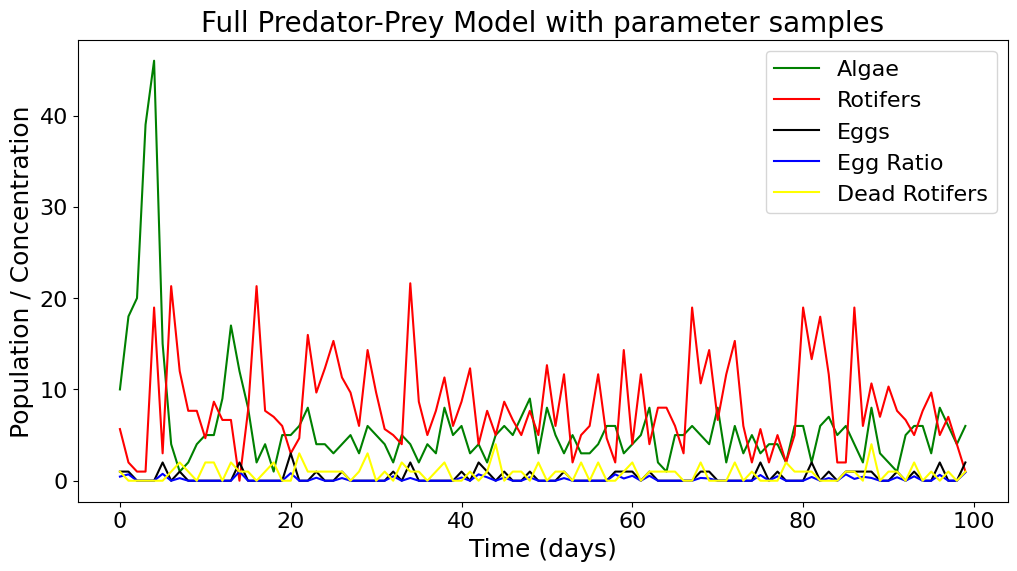

In [58]:
# As an example, we can sample from the priors and then visualize the simulation
params = {key: prior.rvs() for key, prior in priors.items()}

print("Sampled parameters:")
print(json.dumps(params, indent=2))

# Initial conditions: [N, P, E, J, A, D]
initial_conditions = [80, 10, 1, 1, 1, 1]
t_range = (0, 100, 1000)  # Simulate for 100 days with 1000 time points

# Run the model
model = FullPredatorPreyModel(params, initial_conditions, t_range, randomize=True)
solution = model.simulate()
discrete_solution = model.discretize_solution(solution, new_dt=1)
model.plot_results(
    discrete_solution,
    title="Full Predator-Prey Model with parameter samples"
)

### 2.5 Create and Save Simulated Data

Using these defined priors we now create data using different simulators which we save in csv format for further use in SBI in the same manner as the experiment data. Additionally, we save the parameters for each run in a JSON file.

In [ ]:
output_dir = DATA_DIR / 'simulated' / 'full_predator_prey'
simulations_dir = output_dir / 'simulations'
params_dir = output_dir / 'params'

os.makedirs(simulations_dir, exist_ok=True)
os.makedirs(params_dir, exist_ok=True)

num_samples = 1000
num_days = 300

create_and_save_simulated_data(FullPredatorPreyModel, priors, num_samples, num_days, initial_conditions, simulations_dir, params_dir)

### 2.6 Visualize Simulated Data

In [4]:
def plot_full_data(df, units, time_period=None, title="Full Data Plot", show=True, save=False):
    plt.figure(figsize=(10, 5))

    # Filter time period if needed
    if time_period:
        df = df[(df["Time"] >= time_period[0]) & (df["Time"] <= time_period[1])]

    # Normalize values
    algae = df["Algae"]
    rotifers = df["Rotifers"]
    eggs = df["Eggs"]
    egg_ratio = df["Egg_Ratio"]
    dead_animals = df["Dead_Rotifers"]

    time = df["Time"]

    # Plot with markers and lines
    plt.plot(time, algae, 'go-', label='Algae')
    plt.plot(time, rotifers, 'ro-', label='Rotifers')
    plt.plot(time, eggs, 'ko-', label='Eggs')
    plt.plot(time, egg_ratio, 'bo-', label='Egg Ratio')
    plt.plot(time, dead_animals, 'yo-', label='Dead Rotifers')


    plt.title(title)
    plt.xlabel(f"Time ({units['time']})")
    plt.ylabel("Abundance")
    plt.legend()
    plt.grid()

    if save:
        plt.savefig(FIGURES_DIR / "2-data-simulation" / f"{title}.png")

    if show:
        plt.show()
    else:
        plt.close()

In [5]:
simulated_data_dir = DATA_DIR / 'simulated'
simulations_dir = simulated_data_dir / 'full_predator_prey' / 'simulations'
params_dir = simulated_data_dir / 'full_predator_prey' / 'params'

data_files = sorted(simulations_dir.glob('*.csv'), key=lambda x: int(x.stem.split('_')[-1]))

params_dict = dict(json.load(open(params_dir / 'FullPredatorPreyModel_params.json')))
dfs = {f.stem: pd.read_csv(f) for f in data_files}

In [6]:
column_unit_dict = {
    'time': 'days',
    'algae': '10^6 cells/ml',
    'rotifers': 'animals/ml', 
    'egg-ratio': None,
    'eggs': 'per ml',
    'dead animals': 'per ml',
    'external medium': 'mu mol N / l'
}

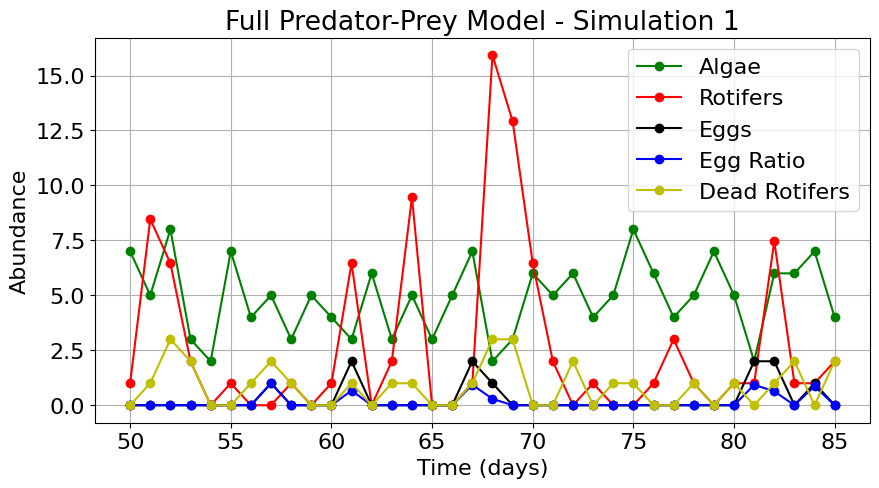

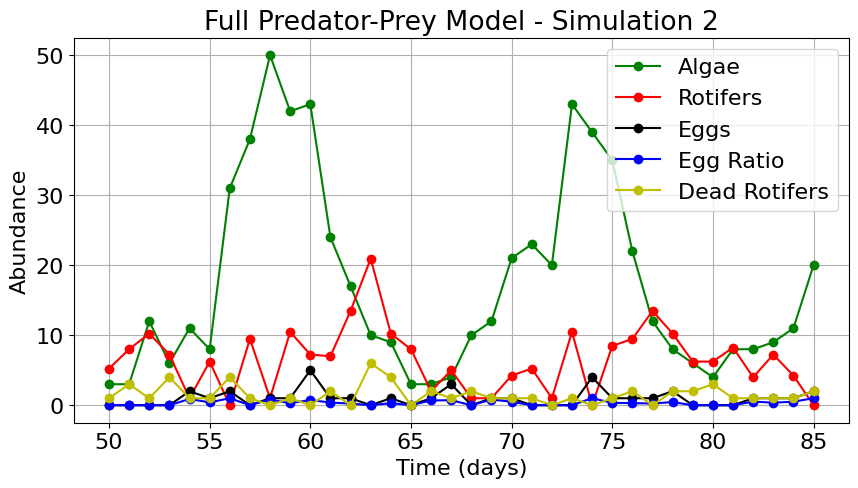

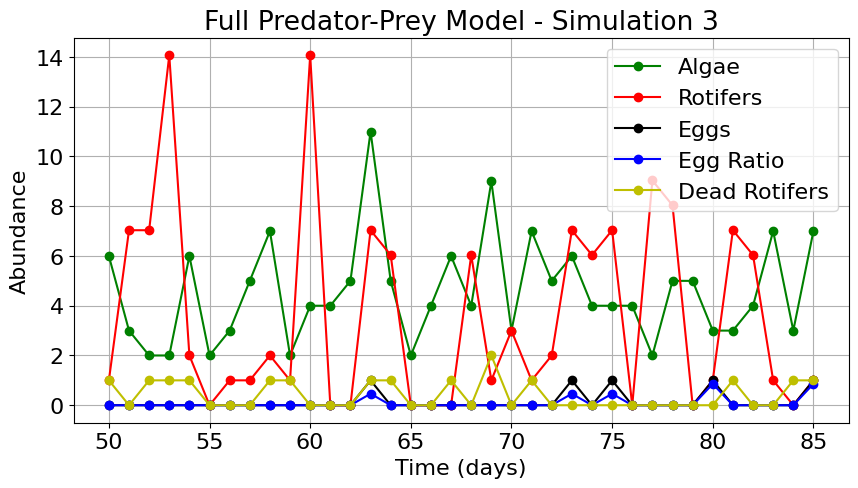

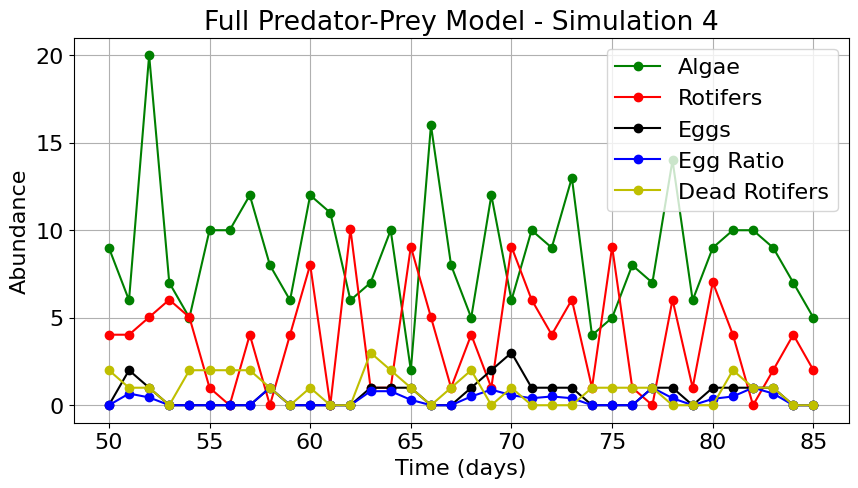

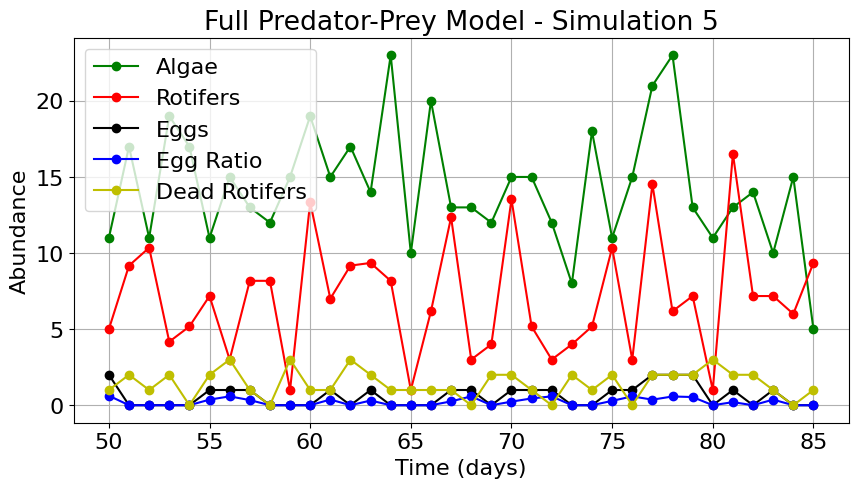

In [7]:
# Plot the first 5 simulations

for i, (name, df) in enumerate(dfs.items()):
    if i >= 5:
        break

    title = f"Full Predator-Prey Model - Simulation {i+1}"
    plot_full_data(df, column_unit_dict, time_period=[50, 85], title=title, show=True, save=True)
